# Машинное обучение, ШАД
## Домашнее задание 12



In [53]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import Callable, Dict, List, Sequence, Tuple, Union

import torch
from torch import nn
import torchvision
from torchvision import transforms

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

sns.set(style="darkgrid", palette="Set2")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


&#x2757; **Весь код работы с библиотекой PyTorch / PyTorch Lightning необходимо написать самостоятельно, без использования ИИ-инструментов.** Но можно использовать код из ноутбуков, рассказанных на занятии. Можно использовать ИИ-инструменты для написания технического кода (например, построение графиков), оформления ранее написанного кода и в качестве справки. Выводы необходимо делать самостоятельно.

### Ссылки на использование ИИ

Если при решении задач использовался ИИ, укажи здесь публичные ссылки на все чаты с ИИ и поясни, для каких целей он применялся. Обрати внимание на <a href="https://thetahat.ru/courses/ai-rules">правила</a>.

**Задача 1**
1. ссылка
    - для чего использована
    - для чего использована
2. ссылка
    - для чего использована

**Задача 2**
1. ссылка
    - для чего использована


---
### Задача 1.

Контест

---

### Задача 2.
Вы научите нейронную сеть классифицировать произведения искусства различных художников, то есть определять, к какому художнику относится картина.

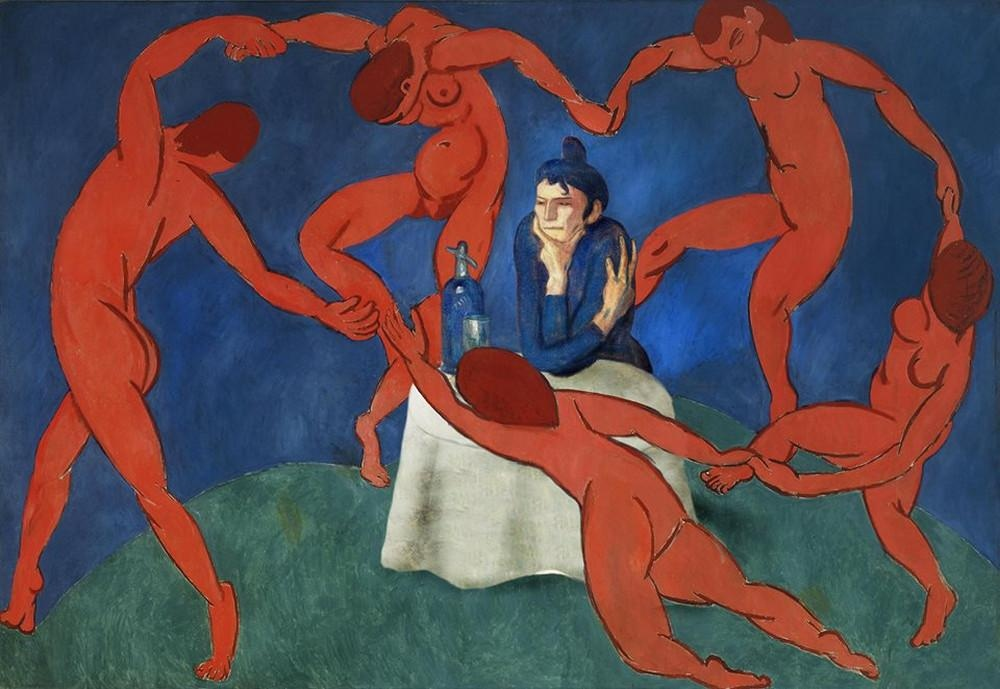

#### 0. Инструменты
Это задание **можно выполнять на чистом PyTorch или Pytorch Lightning**.

Для визулиализации лоссов, метрик и прочего **можно использовать matplotlib, seaborn, как раньше, или TensorBoard**. Обязательно визуализируйте ошибку (лосс) и метрику качества моедели на обучающей и тестовой частях выборки во время обучения для каждой серии экспериментов.

**Если вы решите работать с TensorBoard, вам нужно будет повторно визуализировать графики с помощью matplotlib или seaborn.** Иначе они не будут видны проверяющим. Для этого вам пригодится `EventAccumulator` из `tensorboard.backend.event_processing.event_accumulator`. Логи любого эксперимента будут храниться в файле, который содержит в названии `tfevents`. Считать и сохранить его содержимое можно с помощью следующего кода:

```python
# Заводим список, в котором будут храниться считанные данные
data = []

# Загружаем данные
ea = EventAccumulator(file_path, size_guidance={'scalars': 0})
ea.Reload()

# Получаем список тегов (loss, F1-score и т.д.)
tags = ea.Tags().get('scalars', [])

for tag in tags:
    events = ea.Scalars(tag)
    for event in events:
        data.append({
            'step': event.step,
            'value': event.value,
            'tag': tag,
            'experiment': experiment_name  # Важная колонка для группировки!
        })
```

#### 1. Данные
Скачайте архив с датасетом по [ссылке](https://disk.yandex.ru/d/_BUueJa4RVXplQ).

> Если вы работаете в **Google Colab**, то удобнее всего будет скачать архив на Google Drive (диск). В таком случае не придестя загружать архив вручную каждый раз, когда обрывается runtime. Для этого перейдите в левую  боковую панель, нажмите на кнопку с папочкой, а затем на кнопку с папочкой с изображением Google Drive. Теперь все файлы с диска доступны по пути `drive/MyDrive/`.
>
> Если вы работаете в **Kaggle**, то для того, чтобы загрузить данные, перейдите в правую боковую панель. В разделе `Data` возле кнопки `Add Data` расположена кнопка загрузки данных. Нажмите на нее, появится панель `Create a New Dataset`. Назовите новый датасет. Загрузите туда архив.  После того, как датасет будет проверен, он повится у вас в датасетах. Для того, чтобы начать с ним работать в ноутбуке в Kaggle нужно снова перейти в раздел `Data` и нажать `Add Data`. Затем нажмите кнопку `Your Datasets` и нажмите на плюс возле вашего датасета. После этго датасет появится в а разделе `Data`. Причем Kaggle разархивирует данные за вас.

Для того, чтобы разархивировать данные, выполните следующие действия.

In [11]:
# Запишите путь до архива.
zip_path = "artworks.zip"
# Замените пробелы в пути, чтобы следующая bash-команда работала корректно.
zip_path_bash = str(zip_path).replace(" ", "\ ")
# Разархивируйте файлы.
!unzip $zip_path_bash -d ./artworks
# Укажите путь до данных.
data_path = Path("./artworks")

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Данные содержат папку с изображениями `images` и таблицу с основной информацией про художников `artists.csv`. Папка `images` в свою очередь состоит из папок `train` и `test` с обучающим и тестовым наборами данных соответственно. Рассмотрим, например, папку с тренировочным набором данных.

In [19]:
sorted((data_path / "images" / "train").iterdir())

[WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Alfred_Sisley'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Amedeo_Modigliani'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Andrei_Rublev'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Andy_Warhol'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Camille_Pissarro'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Caravaggio'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Claude_Monet'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Diego_Rivera'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Diego_Velazquez'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Edgar_Degas'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Edouard_Manet'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/im

Она содержит папки, соответствующие художникам в датасете. В каждой такой папке находится тренирвочный набор картин художника.

In [20]:
sorted((data_path / "images" / "train" / "Albrecht_Durer").iterdir())

[WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_001.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_002.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_004.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_005.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_006.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_007.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_008.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_010.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Durer/Albrecht_Durer_011.jpg'),
 WindowsPath('C:/Users/User/Desktop/SAD/artworks/images/train/Albrecht_Du

Приведем примеры изображений.

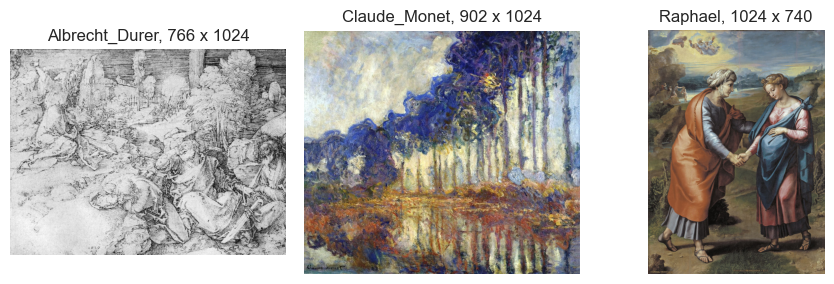

In [21]:
images_paths = [
    data_path / "images" / "train" / "Albrecht_Durer" / "Albrecht_Durer_310.jpg",
    data_path / "images" / "train" / "Claude_Monet" / "Claude_Monet_007.jpg",
    data_path / "images" / "train" / "Raphael" / "Raphael_100.jpg",
]
plt.figure(figsize=(9, 3))
for i, image_path in enumerate(images_paths):
    author = image_path.parent.name
    plt.subplot(1, 3, i + 1)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f"{author}, {image.shape[0]} x {image.shape[1]}")
    plt.axis("off")
plt.tight_layout()

Заметьте, что все картины разных пропорций и размеров, это нужно учесть при обучении модели. Чтобы привести картины к одному размеру можно использовать аугментации, см. пример с Симпсонами в семинаре.


Теперь посмотрим на таблицу с характеристиками художников.



In [22]:
pd.read_csv(data_path / "artists.csv")

,name,years,genre,nationality,bio,wikipedia,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


Наша цель &mdash; построить классификатор картин по художникам. В колонке `paintings` указано общее число картин для каждого худодника. Можно заметить большую несбалансированность классов. Поэтому в начале мы будем работать с художниками, для которых в сумме представлено не менее 200 картин.

In [46]:
artists = pd.read_csv(data_path / "artists.csv")
selected_artists = artists[artists["paintings"] >= 200]["name"].tolist()
selected_artists = list(map(lambda x: x.replace(" ", "_"), selected_artists))
selected_artists

['Vincent_van_Gogh',
 'Pablo_Picasso',
 'Pierre-Auguste_Renoir',
 'Francisco_Goya',
 'Albrecht_Dürer',
 'Alfred_Sisley',
 'Marc_Chagall',
 'Edgar_Degas',
 'Rembrandt',
 'Titian',
 'Paul_Gauguin']

Для обучения вам понадобится построить датасет. Удобнее всего будет воспользоваться `torchvision.datasets.ImageFolder`, см. пример в семинаре с Симпсонами.

In [ ]:
train_dir = r"C:\Users\User\Desktop\SAD\artworks1\images\train"

'C:\\Users\\User\\Desktop\\SAD\\artworks1\\images\\train'

In [108]:
class SplitImageFolder:
    """
    Класс для подготовки и разделения датасета изображений на обучающую и валидационную выборки.
    Предполагается структура папок: train_dir/class_name/image.jpg.
    """

    def __init__(self, train_dir: str) -> None:
        """
        Инициализирует объект, сканирует директорию и извлекает метки классов.

        Args:
            train_dir (str): Путь к корневой директории с изображениями для обучения.
        """

        self.train_dir = train_dir

        # Пути до всех файлов в папке train_dir
        self.train_val_files_path = glob.glob(f"{train_dir}/*/*.jpg")

        # Лейблы для всех файлов в папке train_dir
        self.train_val_labels = [path.split("\\")[-2] for path in self.train_val_files_path]

    def split(self, test_size: float = 0.3) -> Dict[str, List[str]]:
        """
        Производит стратифицированное разбиение файлов на train и val.

        Args:
            test_size (float): Доля данных, выделяемая под валидацию (от 0.0 до 1.0).

        Returns:
            Dict[str, List[str]]: Словарь с ключами 'train' и 'val', содержащий списки путей к файлам.
        """
        # Разделяем файлы на трейн и валидацию
        train_files_path, val_files_path = train_test_split(
            self.train_val_files_path, test_size=test_size, stratify=self.train_val_labels
        )

        # Сохраняем все трейн и валидацию
        files_path = {"train": train_files_path, "val": val_files_path}

        return files_path

In [ ]:
files_path = SplitImageFolder(train_dir).split()

In [111]:
train_files_set = {Path(x) for x in files_path["train"]}
val_files_set = {Path(x) for x in files_path["val"]}

In [112]:
input_size = 200

# Трансформация / аугментация для обучающих картинок
train_transform = transforms.Compose(
    [
        # Меняем размер картинки, наименьшая из сторон становится размера input_size
        transforms.Resize(input_size),
        # Вырезаем из центра квадрат размера input_size x input_size
        transforms.CenterCrop(input_size),
        transforms.ColorJitter(0.9, 0.9, 0.9),  # Меняем случайно цвета
        transforms.RandomAffine(5),  # Применяем случайное аффинное преобразование
        transforms.ToTensor(),  # Приводим к тензору
    ]
)

# Трансформация для валидации
val_transform = transforms.Compose(
    [  # Меняем размер картинки, наименьшая из сторон становится размера input_size
        transforms.Resize(input_size),
        # Вырезаем из центра квадрат размера input_size x input_size
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),  # Приводим к тензору
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transform,
    is_valid_file=lambda x: Path(x) in train_files_set
)

val_dataset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=val_transform,
    is_valid_file=lambda x: Path(x) in val_files_set
)

#### 2. Fine-tuning
Выберите одну из сверточных моделей из этого списка [здесь](https://pytorch.org/vision/stable/models.html) для fine-tuning. Не используйте ViT, SWIN и MaxViT, так как трансформерные модели не рассматривались на занятии. Объясните свой выбор.

**Ответ:**

...

Как вы думаете, какой вариант fine-tuning больше подходит для данной задачи?

**Ответ:**

...

Проведите эксперименты по дообучению (fine-tuning) модели, используя минимум три различные конфигурации размороженных слоев. В ходе обучения отслеживайте динамику функции потерь (Loss) и метрики F1 Macro на обучающей и тестовой частях выборки.

> Под **F1 Macro** подразумевается вычисление F1-score независимо для каждого класса с последующим усреднением всех полученных значений.
>
> Обратите внимание, что расчет метрики должен производиться на полном наборе данных за эпоху (accumulated metric), а не путем усреднения значений по мини-батчам. При использовании PyTorch Lightning реализуйте логику агрегации предсказаний и итогового подсчета в методах `on_train_epoch_end` и `on_validation_epoch_end`.


In [ ]:
...

Поясните, в чем преимущества F1 macro по сравнению с accuracy. Сделайте выводы.

**Вывод:**

...

#### 3. Аугментации


В данном задании для аугментаций предлагается использовать модуль [`torchvision.transforms`](https://docs.pytorch.org/vision/stable/transforms.html).

> **Дополнение данных / Аугментация данных / Data augmentations** &mdash; это метод, направленный на увеличение размеров обучающей выборки. Дополнение обучающей выборки разнообразными, "хорошими" и "плохими" примерами, позволяет получить модель более устойчивую на тестовых данных, так как для неё в тестовых данных будет меньше "неожиданностей".
>
> В первую очередь к изображениям обычно применяют **геометрические изменения**. Сюда входят изменение размера (`Resize`), вырезка центра (`CenterCrop`) или случайного участка (`RandomCrop`), а также мощная комбинация кропа с ресайзом — `RandomResizedCrop`. Для пространственной вариативности часто используют зеркальные отражения по горизонтали (`RandomHorizontalFlip`) или вертикали (`RandomVerticalFlip`), случайные повороты (`RandomRotation`) и аффинные искажения (`RandomAffine`).
>
> Вторая группа отвечает за **манипуляции с цветом и качеством картинки**. Самый универсальный инструмент здесь — `ColorJitter`, меняющий яркость, контраст и насыщенность. Также применяют размытие (`GaussianBlur`), перевод в оттенки серого (`RandomGrayscale`) или инверсию (`RandomInvert`). Отдельно стоит `RandomErasing`, который затирает случайный прямоугольник шумом, имитируя перекрытие объекта.
>
> Завершает процесс **техническая подготовка данных**. Изображения конвертируют в формат, понятный нейросети (`ToTensor`), и приводят к стандартному математическому распределению через нормализацию (`Normalize`). Чтобы применить все описанные аугментации последовательно, их упаковывают в единый конвейер с помощью класса `Compose`.

Подумайте, какие аугментации будут полезны для задачи классификации картин, напишите свой ответ.

**Ответ:**

...

Добавьте аугментации к данным. Визуализируйте несколько аугментированных изображений.

In [ ]:
...

Выберите лучшую модель. Примените fine-tining модели
 на аугментированных данных. Получается ли улучшить качество?

In [ ]:
...

**Вывод:**

...

#### 4. Несбалансированность классов
Расширим выборку до всех классов. Примените fine-tuning для расширенной выборки. Хорошо ли модель предсказывает малопредставленные классы?

In [ ]:
...

В качестве решения проблемы несбалансированности классов можно взвешивать лосс. Если это [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), то можно указать в параметре `weight` веса классов. Также можно поменять стратегию семплирования при обучении, для этого можно использовать [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) в качестве параметра `sampler` в `dataloader`. Подумайте, как еще можно можно решить эту проблему. Попробуйте одну из стратегий. Получается ли улучшить качество?

In [ ]:
...

#### 5. Выводы

Сделайте общий вывод по задаче.

**Вывод:**

...

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД